<a href="https://colab.research.google.com/github/wldopie/ESAA/blob/main/%5B%EC%88%98%EC%83%81%EC%9E%91_%EC%8A%A4%ED%84%B0%EB%94%94_2%EC%A1%B0%5D_2%EC%A3%BC%EC%B0%A8_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **월간 데이콘 소설 작가 분류 AI 경진대회**
> 링크 : https://dacon.io/codeshare/2357?page=1&dtype=recent

---

## **0. 라이브러리 임포트**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

---

## **1. NLP Preprocessing**

### **1.1 데이터 불러오기**

In [3]:
# 압축파일 해제
!unzip -qq '/content/drive/MyDrive/[22-2] ESAA 스터디/235670_소설 작가 분류 AI 경진대회_data.zip'

In [4]:
# train 데이터 불러오기
train = pd.read_csv('/content/train.csv')
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [5]:
# test 데이터 불러오기
test = pd.read_csv('/content/test_x.csv')
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [6]:
# sample_submission 불러오기
sample_submission = pd.read_csv('/content/sample_submission.csv')
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


### **1.2 불용어 제거**

In [7]:
# 부호 제거하는 함수
def alpha_num(text):
  return re.sub(r'[^A-Za-z0-9]', ' ', text)

# 불용어 제거하는 함수
def remove_stopwords(text):
  final_text = []
  for i in text.split():
    if i.strip().lower() not in stopwords:
      final_text.append(i.strip())
  return ' '.join(final_text)

# 불용어 지정
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# 소문자로 바꾼 후 전처리 적용
train.text = train.text.str.lower()
test.text = test.text.str.lower()

train.text = train.text.apply(alpha_num).apply(remove_stopwords)
test.text = test.text.apply(alpha_num).apply(remove_stopwords)

### **1.3 데이터 시각화**

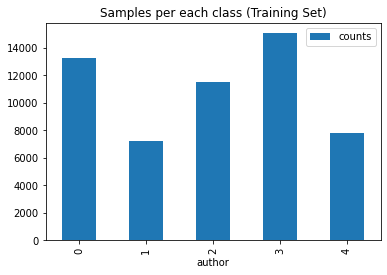

In [8]:
# 작가별 분포도 확인
train.groupby(train.author).size().reset_index(name = 'counts').plot.bar(x = 'author', title = 'Samples per each class (Training Set)')

  - 작가별로 분포도가 상이하다.

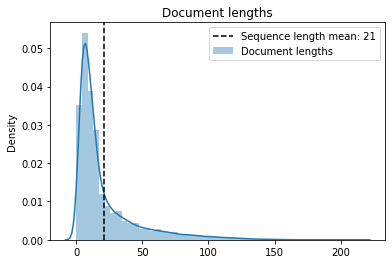

 가장 긴 문장은 214 개의 단어를, 가장 짧은 문장은 0 개의 단어를 가지고 있습니다.


In [9]:
# 문장 길이 분포도 확인
train['doc_len'] = train.text.apply(lambda words : len(words.split()))

def plot_doc_lengths(dataframe):
  mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
  sns.distplot(tuple(dataframe.doc_len), hist = True, kde = True, label = 'Document lengths')
  plt.axvline(x = mean_seq_len, color = 'k', linestyle = '--', label = f'Sequence length mean: {mean_seq_len}')
  plt.title('Document lengths')
  plt.legend()
  plt.show()
  print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

  - 필사한 코드와 비교했을 때 max 값은 3만큼, 평균값은 1만큼 차이가 난다.
  - 위 그래프를 통해 알 수 있듯이 평균 길이는 21이다. 따라서 차후 sequence에 적용할 max length는 150 정도로 적당히 잡아준다.

---

## **2. Vectorization**

### **2.1 Tokenization**

In [10]:
# 먼저 train 데이터와 test 데이터를 인덱스 없이 배열로 만들기
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
Y_train = np.array([x for x in train['author']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(54879,)
(19617,)
(54879,)


In [11]:
print(X_train)
print(X_test)
print(Y_train)

['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity'
 'sister asked suppose'
 'engaged one day walked perusing jane s last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'
 ... 'sincere well wisher friend sister lucy odin' 'wanted lend money'
 'certainly not occurred said yes like']
['not think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment'
 'no replied sudden consciousness not find cannot ignorant goodness owe feel express well know no orator'
 'lady stated intention screaming course screamed additional boldness exertion rendered unnecessary hasty knocking door no sooner heard mr odin darted much agility wine bottl

In [12]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000

tokenizer = Tokenizer(num_words = vocab_size)
  # Tokenizer는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서
  # num_words에 지정된 만큼만 숫자로 반환하고, 나머지는 0으로 반환합니다.
tokenizer.fit_on_texts(X_train)   # Tokenizer에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)   # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)     # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

54879 19617


---

## **3. Embedding**

In [13]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [14]:
# 독립변수 데이터 전처리
  ## 문장의 길이가 제각각이므로 벡터의 크기가 전부 상이
  ## 그러므로 최대 시퀀스 길이 크기(214) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 150    # 위에서 그래프 확인 후 적정한 수로 결정
padding_type = 'post'

train_x = pad_sequences(sequences_train, padding = padding_type, maxlen = max_length)
test_x = pad_sequences(sequences_test, padding = padding_type, maxlen = max_length)

print(train_x.shape, test_x.shape)

(54879, 150) (19617, 150)


In [15]:
# 종속변수 데이터 전처리
train_y = np_utils.to_categorical(Y_train)    # Y_train에 원=핫 인코딩
print(train_y)
print(train_y.shape)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
(54879, 5)


---

## **4. Modeling**

### **4.1 Simple RNN**

In [16]:
# 파라미터 설정
vocab_size = 2000   # 가장 많이 사용하는 사이즈
embedding_dim = 200
max_length = 150    # 위 그래프에서 확인 후 적정한 수로 결정
padding_type = 'post'

In [17]:
# Simple RNN 레이어를 사용한 모델 (Model_1) 정의
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
                     tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
                     tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
                     tf.keras.layers.SimpleRNN(units = 64),
                     Dense(5, activation = 'softmax')   # 결과값이 0~4이므로, Dense(5)로 지정
          ])

model1.compile(loss = 'categorical_crossentropy',   # 여러 개의 정답 중 하나를 맞추는 문제이므로, 손실 함수는 categorical_crossentropy
               optimizer = 'adam',
               metrics = ['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 200)          400000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 150, 64)           16960     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 150, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 433,797
Trainable params: 433,797
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 모델 실행
history = model1.fit(train_x, train_y, epochs = 10, batch_size = 100, validation_split = 0.2)
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch_size를 100으로 크게 설정
  # 추이를 확인하기 위해 일단 10회만 시도

Epoch 1/10
440/440 [==============================] - 242s 533ms/step - loss: 1.5794 - accuracy: 0.2636 - val_loss: 1.5773 - val_accuracy: 0.2680
Epoch 2/10
440/440 [==============================] - 206s 468ms/step - loss: 1.5742 - accuracy: 0.2679 - val_loss: 1.5756 - val_accuracy: 0.2678
Epoch 3/10
440/440 [==============================] - 203s 461ms/step - loss: 1.5749 - accuracy: 0.2692 - val_loss: 1.5749 - val_accuracy: 0.2680
Epoch 4/10
440/440 [==============================] - 201s 457ms/step - loss: 1.5731 - accuracy: 0.2701 - val_loss: 1.5716 - val_accuracy: 0.2679
Epoch 5/10
440/440 [==============================] - 201s 458ms/step - loss: 1.5728 - accuracy: 0.2720 - val_loss: 1.5755 - val_accuracy: 0.2680
Epoch 6/10
440/440 [==============================] - 199s 452ms/step - loss: 1.5729 - accuracy: 0.2706 - val_loss: 1.5712 - val_accuracy: 0.2680
Epoch 7/10
440/440 [==============================] - 201s 457ms/step - loss: 1.5722 - accuracy: 0.2721 - val_loss: 1.5766 -

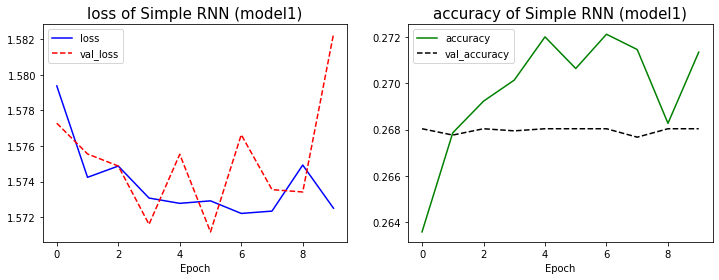

In [19]:
# Simple RNN 모델 (Model_1) 학습 결과 확인
plt.figure(figsize = (12, 4))
plt.title('Simple RNN (model1)', fontsize = 15)

plt.subplot(1, 2, 1)
plt.title('loss of Simple RNN (model1)', fontsize = 15)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Simple RNN (model1)', fontsize = 15)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

  - Simple RNN은 한 Epoch당 시간도 오래 걸리고, 학습이 되지 않는 것을 확인할 수 있다.

### **4.2 단방향 LSTM**

In [20]:
# 파라미터 정의
vocab_size = 2000   # 가장 많이 사용하는 사이즈
embedding_dim = 200
max_length = 150    # 위에서 그래프 확인 후 적정한 수로 결정
padding_type = 'post'

In [21]:
# LSTM 레이어를 사용한 모델 (Model_2) 정의
model2 = Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
                     tf.keras.layers.LSTM(units = 64, return_sequences = True),
                     tf.keras.layers.LSTM(units = 64, return_sequences = True),
                     tf.keras.layers.LSTM(units = 64),
                     Dense(5, activation = 'softmax')   # 결과값이 0~4이므로, Dense(5)로 지정
          ])

model2.compile(loss = 'categorical_crossentropy',   # 여러 개의 정답 중 하나를 맞추는 문제이므로, 손실 함수는 categorical_crossentropy 
               optimizer = 'adam',
               metrics = ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 200)          400000    
                                                                 
 lstm (LSTM)                 (None, 150, 64)           67840     
                                                                 
 lstm_1 (LSTM)               (None, 150, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 534,213
Trainable params: 534,213
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 모델 실행
history = model2.fit(train_x, train_y, epochs = 10, batch_size = 100, validation_split = 0.20)
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리므로, batch size를 100으로 크게 설정정
  # 추이를 확인하기 위해 일단 10회만 시도

Epoch 1/10
440/440 [==============================] - 40s 76ms/step - loss: 1.5722 - accuracy: 0.2741 - val_loss: 1.5714 - val_accuracy: 0.2680
Epoch 2/10
440/440 [==============================] - 15s 34ms/step - loss: 1.5706 - accuracy: 0.2761 - val_loss: 1.5721 - val_accuracy: 0.2680
Epoch 3/10
440/440 [==============================] - 13s 30ms/step - loss: 1.5706 - accuracy: 0.2761 - val_loss: 1.5721 - val_accuracy: 0.2680
Epoch 4/10
440/440 [==============================] - 11s 26ms/step - loss: 1.5706 - accuracy: 0.2761 - val_loss: 1.5715 - val_accuracy: 0.2680
Epoch 5/10
440/440 [==============================] - 11s 24ms/step - loss: 1.5704 - accuracy: 0.2761 - val_loss: 1.5716 - val_accuracy: 0.2680
Epoch 6/10
440/440 [==============================] - 10s 23ms/step - loss: 1.5704 - accuracy: 0.2762 - val_loss: 1.5722 - val_accuracy: 0.2680
Epoch 7/10
440/440 [==============================] - 11s 26ms/step - loss: 1.5704 - accuracy: 0.2761 - val_loss: 1.5716 - val_accuracy:

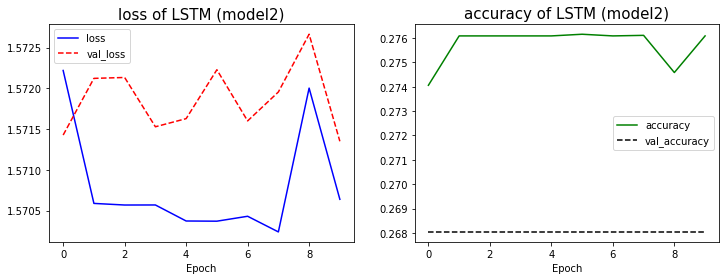

In [23]:
# 모델 학습 결과 확인
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model2)', fontsize = 15)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model2)', fontsize = 15)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

  - 단방향 LSTM 결과, 학습 시간은 단축되었으나 학습은 되지 않는 것을 확인할 수 있다.

### **4.3 양방향 LSTM**

In [24]:
# 파라미터 설정
vocab_size = 2000   # 가장장 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 150    # 위에서 그래프 확인 후 적정한 수로 결정
padding_type='post'
#oov_tok = "<OOV>"

In [25]:
# 양방향 LSTM 레이어를 사용한 모델 (Model_3) 정의
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
                     tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
                     tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
                     tf.keras.layers.Bidirectional(LSTM(units = 64)),
                     Dense(5, activation = 'softmax')   # 결과값이 0~4이므로, Dense(5)
          ])

model3.compile(loss = 'categorical_crossentropy',   # 여러 개의 정답 중 하나를 맞추는 문제이므로, 손실 함수는 categorical_crossentroopy
               optimizer = 'adam',
               metrics = ['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 200)          400000    
                                                                 
 bidirectional (Bidirectiona  (None, 150, 128)         135680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                      

In [26]:
# 모델 실행
history = model3.fit(train_x, train_y, epochs = 50, batch_size = 100, validation_split = 0.2)
  # 양방향 LSTM 레이어에서는 batch size를 100으로 잡고 50회 학습을 진행

Epoch 1/50
440/440 [==============================] - 54s 97ms/step - loss: 1.0987 - accuracy: 0.5581 - val_loss: 0.9259 - val_accuracy: 0.6498
Epoch 2/50
440/440 [==============================] - 23s 52ms/step - loss: 0.8572 - accuracy: 0.6720 - val_loss: 0.8659 - val_accuracy: 0.6718
Epoch 3/50
440/440 [==============================] - 21s 47ms/step - loss: 0.7922 - accuracy: 0.6989 - val_loss: 0.8740 - val_accuracy: 0.6717
Epoch 4/50
440/440 [==============================] - 20s 46ms/step - loss: 0.7521 - accuracy: 0.7123 - val_loss: 0.8774 - val_accuracy: 0.6696
Epoch 5/50
440/440 [==============================] - 20s 46ms/step - loss: 0.7195 - accuracy: 0.7243 - val_loss: 0.8778 - val_accuracy: 0.6735
Epoch 6/50
440/440 [==============================] - 20s 46ms/step - loss: 0.6931 - accuracy: 0.7344 - val_loss: 0.9062 - val_accuracy: 0.6679
Epoch 7/50
440/440 [==============================] - 19s 44ms/step - loss: 0.6631 - accuracy: 0.7448 - val_loss: 0.9166 - val_accuracy:

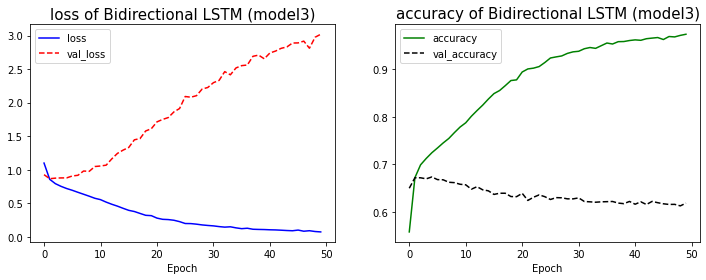

In [27]:
# 모델 학습 결과 확인
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model3)', fontsize = 15)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model3)', fontsize = 15)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

  - train 데이터의 loss는 줄어들지만, val_loss는 점점 상승한다.
  - accuracy 역시 train 데이터의 경우 높아지지만, val_accuracy에서는 점점 하락한다.

### **4.4 교차 검증 적용**
  - StratifiedKFold를 적용하여 모델 일반화

In [28]:
# 계층 교차 검증
n_fold = 5
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
  print(f'training model for CV #{i}')

  model3.fit(train_x[i_trn],
             to_categorical(Y_train[i_trn]),
             validation_data = (train_x[i_val], to_categorical(Y_train[i_val])),
             epochs = 10,
             batch_size = 512)

training model for CV #1
Epoch 1/10
86/86 [==============================] - 17s 202ms/step - loss: 0.5106 - accuracy: 0.9015 - val_loss: 0.3842 - val_accuracy: 0.9083
Epoch 2/10
86/86 [==============================] - 13s 147ms/step - loss: 0.3087 - accuracy: 0.9246 - val_loss: 0.3681 - val_accuracy: 0.9097
Epoch 3/10
86/86 [==============================] - 13s 152ms/step - loss: 0.2579 - accuracy: 0.9353 - val_loss: 0.3682 - val_accuracy: 0.9076
Epoch 4/10
86/86 [==============================] - 11s 130ms/step - loss: 0.2249 - accuracy: 0.9423 - val_loss: 0.3739 - val_accuracy: 0.9081
Epoch 5/10
86/86 [==============================] - 11s 132ms/step - loss: 0.1999 - accuracy: 0.9475 - val_loss: 0.3823 - val_accuracy: 0.9062
Epoch 6/10
86/86 [==============================] - 10s 117ms/step - loss: 0.1793 - accuracy: 0.9529 - val_loss: 0.3912 - val_accuracy: 0.9045
Epoch 7/10
86/86 [==============================] - 10s 116ms/step - loss: 0.1621 - accuracy: 0.9571 - val_loss: 0.40

  - 기존보다 개선된 결과값을 보이지만, val_loss와 val_accuracy는 여전히 개선이 필요하다.
  - val_loss와 val_accuracy 결과값을 보면, 조기종료 옵션을 추가하는 것이 필요할 것으로 보인다.

In [29]:
# 계층 교차 검증
n_fold = 5
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)

# 테스트 데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 5))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 3,
                   verbose = 1, mode = 'min', baseline = None, restore_best_weights = True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
  print(f'training model for CV #{i}')

  model3.fit(train_x[i_trn],
             to_categorical(Y_train[i_trn]),
             validation_data = (train_x[i_val], to_categorical(Y_train[i_val])),
             epochs = 10,
             batch_size = 512,
             callbacks = [es])    # 조기 종료 옵션

  test_y += model3.predict(test_x) / n_fold   # 나온 예측값들을 교차 검증 횟수로 나눈다.

training model for CV #1
Epoch 1/10
86/86 [==============================] - 10s 117ms/step - loss: 0.0767 - accuracy: 0.9729 - val_loss: 0.0666 - val_accuracy: 0.9770
Epoch 2/10
86/86 [==============================] - 10s 116ms/step - loss: 0.0786 - accuracy: 0.9719 - val_loss: 0.0870 - val_accuracy: 0.9677
Epoch 3/10
86/86 [==============================] - 10s 114ms/step - loss: 0.0589 - accuracy: 0.9782 - val_loss: 0.0897 - val_accuracy: 0.9675
Epoch 4/10
86/86 [==============================] - 10s 111ms/step - loss: 0.0477 - accuracy: 0.9819 - val_loss: 0.0990 - val_accuracy: 0.9669
Epoch 4: early stopping
614/614 [==============================] - 10s 14ms/step
training model for CV #2
Epoch 1/10
86/86 [==============================] - 10s 111ms/step - loss: 0.0684 - accuracy: 0.9745 - val_loss: 0.0667 - val_accuracy: 0.9755
Epoch 2/10
86/86 [==============================] - 10s 112ms/step - loss: 0.0515 - accuracy: 0.9810 - val_loss: 0.0675 - val_accuracy: 0.9752
Epoch 3/10


### **4.5 테스트 데이터 적용**

In [30]:
# 테스트 데이터의 예측값 확인
test_y

array([[2.46717861e-08, 9.99999493e-01, 1.81935501e-07, 2.92720613e-07,
        1.39211745e-08],
       [6.68620016e-01, 3.26708068e-01, 1.98154282e-04, 2.84978320e-04,
        4.18879447e-03],
       [8.45710916e-04, 6.24737856e-03, 5.65519235e-05, 4.95302115e-03,
        9.87897292e-01],
       ...,
       [2.09750329e-08, 9.99999911e-01, 5.70549490e-08, 4.88189485e-09,
        2.48345046e-08],
       [4.57523281e-08, 9.99999791e-01, 4.15197972e-08, 1.67582531e-07,
        3.19207270e-08],
       [5.64456447e-04, 3.28030250e-05, 9.99365106e-01, 3.49549221e-05,
        2.66826993e-06]])

In [31]:
# sample_submission에 대입
sample_submission[['0', '1', '2', '3', '4']] = test_y
sample_submission

,index,0,1,2,3,4
0,0,2.467179e-08,0.999999,1.819355e-07,2.927206e-07,1.392117e-08
1,1,6.686200e-01,0.326708,1.981543e-04,2.849783e-04,4.188794e-03
2,2,8.457109e-04,0.006247,5.655192e-05,4.953021e-03,9.878973e-01
3,3,7.556477e-05,0.000040,9.998679e-01,1.487590e-05,1.342507e-06
4,4,9.815386e-01,0.000012,1.670785e-03,5.781176e-03,1.099726e-02
...,...,...,...,...,...,...
19612,19612,3.773373e-06,0.999988,2.123892e-06,3.649735e-07,5.697383e-06
19613,19613,1.995911e-01,0.000250,1.860303e-03,2.085594e-03,7.962127e-01
19614,19614,2.097503e-08,1.000000,5.705495e-08,4.881895e-09,2.483450e-08
19615,19615,4.575233e-08,1.000000,4.151980e-08,1.675825e-07,3.192073e-08
